<a href="https://colab.research.google.com/github/ashishkumarsaklani/AIML/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans,SpectralClustering


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')

import re
import itertools
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#importing data

In [ ]:

url ='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


#Custom Class

In [ ]:

job_roles = df['job_position'].astype(str)  #
# Fill NaN values with 'Not Disclosed'
df['job_position'] = df['job_position'].fillna('Not Disclosed')

# Define a function to normalize job titles
def normalize_job_title(title):
    # Convert to lowercase and remove whitespace
    title = title.lower().strip()
    # Remove "II" or "2" at the end of the title
    title = re.sub(r'\s*[IVXLCDM]+\s*$', '', title)
    # Remove "II" or "2" at the end of the title
    title = re.sub(r'\s*2$', '', title)
    return title

# Apply the normalization function to the job titles
df['normalized_job_position'] = df['job_position'].apply(normalize_job_title)

# Count the occurrences of each normalized job title
job_counts = df['normalized_job_position'].value_counts()

# Print the top 50 job titles and their counts

job = list(job_counts.head(90).index)
#job





# Assuming job_roles is a list of job titles
# If not, please replace job_roles with your actual list of job titles
job_roles = job
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

preprocessed_job_roles = [preprocess_text(role) for role in job_roles]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_job_roles)

k = 50  # Adjust as needed
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X)

# Get the most common job titles within each cluster
representative_titles = {}
for cluster_id in range(k):
    cluster_indices = [i for i, label in enumerate(clusters) if label == cluster_id]
    common_job_titles = [job_roles[i] for i in cluster_indices]
    # Counting the frequency of job titles
    title_counts = Counter(common_job_titles)
    # Get the most common job title
    most_common_title = title_counts.most_common(1)[0][0]
    representative_titles[cluster_id] = most_common_title

def assign_clean_title(job_title):
    if pd.isna(job_title):
        return 'Not Disclosed'
    try:
        return representative_titles.get(clusters[job_roles.index(job_title)], 'Others')
    except ValueError:
        return 'Other'  # Handle the case where job_title is not found in job_roles

# Sample DataFrame
#data = {'job_position': ['Software Developer', 'software engineer', 'Data Analyst', 'Project manager', 'Not Disclosed', 'Software Developer', 'Data Scientist']}
#df = pd.DataFrame(data)

# Applying the function to create a new column 'job_predicted'
df['job_position'] = df['job_position'].apply(lambda x: assign_clean_title(x.lower()))
#df[['job_position','job_predicted']][300:340]





#df['job_position'].unique()
#print(df.head(30))

In [ ]:

import pandas as pd
import numpy as np

class CustomEncoder:
    def __init__(self):
        self.encoding_dict = {}  # Dictionary to store encoding mappings
        self.counter = 1  # Counter to assign integer encoding values

    def fit_transform(self, series):
        encoded_list = []  # List to store encoded values

        # Count the frequency of each item in the series
        frequency_count = series.value_counts().sort_values(ascending=False)

        # Iterate through the series based on frequency count
        for item in series:
            if pd.isna(item):
                encoded_list.append(item)
            elif item not in self.encoding_dict:
                self.encoding_dict[item] = self.counter
                self.counter += 1
                encoded_list.append(self.encoding_dict[item])
            else:
                encoded_list.append(self.encoding_dict[item])

        return encoded_list, self.encoding_dict

    def inverse_transform(self, encoded_list, encoding_dict):
        reverse_dict = {v: k for k, v in encoding_dict.items()}  # Reverse the dictionary for decoding
        return [reverse_dict[encoded_value] if encoded_value in reverse_dict else encoded_value for encoded_value in encoded_list]

In [ ]:
class IQROutlierDetector:

  def __init__(self, data, column_name):

    self.data = data
    self.column_name = column_name

  def detect_outliers(self):


    if not pd.api.types.is_numeric_dtype(self.data[self.column_name]):
      #print(f"Warning: Column '{self.column_name}' is not numerical. Skipping outlier detection.")
      return None  # Indicate non-numerical column

    q1 = self.data[self.column_name].quantile(0.25)
    q3 = self.data[self.column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = self.data[(self.data[self.column_name] < lower_bound) | (self.data[self.column_name] > upper_bound)].index.tolist()
    return outliers

  def get_outlier_count(self):

    outliers = self.detect_outliers()
    if outliers is None:
        return 0  # Handle case of non-numerical column
    else:
        return len(outliers)

  def get_outlier_percentage(self):

    outlier_count = self.get_outlier_count()
    total_data_points = len(self.data)
    if total_data_points > 0:
        return (outlier_count / total_data_points) * 100
    else:
        return 0  # Handle case of empty data

  def drop_outliers(self):

    outliers = self.detect_outliers()
    if outliers is None:
        return self.data  # Return original data if column is not numerical
    else:
        return self.data.drop(outliers)

#renaming column for my convenience

In [ ]:
df.rename(columns={
'Unnamed: 0':'sn',
'company_hash':'company',
'email_hash':'email',
'orgyear':'j_year',
'job_position':'position',
'ctc_updated_year':'i_year'
},inplace=True)

#encoding with custom function

In [ ]:

encoder = CustomEncoder()

input_series = df['position']
df['position'], pos_dict = encoder.fit_transform(input_series)

input_series = df['company']
df['company'], com_dict = encoder.fit_transform(input_series)

input_series = df['email']
df['email'], ema_dict = encoder.fit_transform(input_series)

In [ ]:
#Now checking for missing values

for col in df.columns:
   Mi = df[col].isna().sum()
   print(f"{col} :{Mi}")

sn :0
company :44
email :0
j_year :86
ctc :0
position :0
i_year :0
normalized_job_position :0


In [ ]:


# Feature 1: Average CTC Increase Rate (fill NaN with 0)
df['ctc_increase'] = ((df['ctc'] - df.groupby('email')['ctc'].shift()) / (df['j_year'] - df.groupby('email')['j_year'].shift())).fillna(0)

# Feature 2: Position Change Frequency
df['position_change'] = df.groupby('email')['position'].transform('nunique')

# Feature 3: Job Stability Indicator
df['job_stability'] = (df.groupby('email')['position'].apply(lambda x: x.duplicated(keep=False))).astype(int)

# Feature 4: Industry Experience
current_year = 2025  # Change this to the current year
df['experience'] = current_year - df['j_year']


df['employee_count']= df['company'].map(df['company'].value_counts())
# Display the modified dataframe
print(df.head())

   sn  company  email  j_year      ctc  position  i_year  \
0   0     52.0  37351  2016.0  1100000         1  2020.0   
1   1     53.0  37352  2018.0   449999         2  2019.0   
2   2     54.0  37353  2015.0  2000000         3  2020.0   
3   3     55.0  37354  2017.0   700000         3  2019.0   
4   4     56.0  37355  2017.0  1400000         2  2019.0   

  normalized_job_position  ctc_increase  position_change  job_stability  \
0                   other           0.0                2              0   
1      fullstack engineer           0.0                2              0   
2        backend engineer           0.0                1              1   
3        backend engineer           0.0                1              0   
4      fullstack engineer           0.0                2              0   

   experience  employee_count  
0         9.0             9.0  
1         7.0           429.0  
2        10.0             1.0  
3         8.0            70.0  
4         8.0             6.

#Missing Values

In [ ]:
# Fill missing 'company' values based on non-missing values within the same email group
#df['company'] = df.groupby('email')['company'].transform(lambda x: x.fillna(method='ffill'))
df.dropna(subset= ['company','j_year'],inplace=True,axis=0)

In [ ]:
# Fill missing 'position' values based on non-missing values within the same email group
df['position'] = df.groupby('email')['position'].transform(lambda x: x.fillna(method='ffill'))

In [ ]:
for col in df.columns:
   Mi = df[col].isna().sum()
   print(f"{col} :{Mi}")

sn :0
company :0
email :0
j_year :0
ctc :0
position :0
i_year :0
normalized_job_position :0
ctc_increase :0
position_change :0
job_stability :0
experience :0
employee_count :0


In [ ]:
#pos_dict

In [ ]:
df.head()

,sn,company,email,j_year,ctc,position,i_year,normalized_job_position,ctc_increase,position_change,job_stability,experience,employee_count
0,0,52.0,37351,2016.0,1100000,1,2020.0,other,0.0,2,0,9.0,9.0
1,1,53.0,37352,2018.0,449999,2,2019.0,fullstack engineer,0.0,2,0,7.0,429.0
2,2,54.0,37353,2015.0,2000000,3,2020.0,backend engineer,0.0,1,1,10.0,1.0
3,3,55.0,37354,2017.0,700000,3,2019.0,backend engineer,0.0,1,0,8.0,70.0
4,4,56.0,37355,2017.0,1400000,2,2019.0,fullstack engineer,0.0,2,0,8.0,6.0


#Duplicates

In [ ]:
#checking if there are duplicate and total
df.duplicated().sum()

0

In [ ]:
for col in df.columns:
   dup = df[col].duplicated().sum()
   print(f"{col} :{dup}")

sn :0
company :168439
email :52380
j_year :205636
ctc :202354
position :205662
i_year :205706
normalized_job_position :204811
ctc_increase :205401
position_change :205707
job_stability :205711
experience :205636
employee_count :205448


Serial number of the first column does not have any duplicate values and not relevant we can delete

In [ ]:
df.drop(columns=['sn','normalized_job_position'],inplace=True)

In [ ]:
df['j_year']=df['j_year'].astype('int32')
df['i_year']=df['i_year'].astype('int32')

Sorting values by email to check if the multiple records of a same employee

In [ ]:
sorted_df = df.sort_values(by=['email','j_year'])

sorted_df.head()

,company,email,j_year,ctc,position,i_year,ctc_increase,position_change,job_stability,experience,employee_count
0,52.0,37351,2016,1100000,1,2020,0.0,2,0,9.0,9.0
138010,239.0,37351,2016,1100000,3,2020,0.0,2,0,9.0,5381.0
1,53.0,37352,2018,449999,2,2019,0.0,2,0,7.0,429.0
22950,53.0,37352,2018,449999,1,2019,0.0,2,0,7.0,429.0
2,54.0,37353,2015,2000000,3,2020,0.0,1,1,10.0,1.0


In [ ]:

# Group by hashed email and count the number of records per group
email_counts = df.groupby('email').size()

# Filter groups with more than 8 record (potential duplicates)
duplicate_emails = email_counts[email_counts > 8]

# Display the potential duplicate hashed emails along with their counts
print("Potential Duplicate Hashed Emails:")
print(duplicate_emails)

Potential Duplicate Hashed Emails:
email
46775     9
47089     9
58216    10
90636     9
dtype: int64


Appears like count greater than 8 years not very high it's just 3 we can as you the emails are for a person only not a common emails

#Outliers

In [ ]:
for col in df.columns:
  detector = IQROutlierDetector(df, col)
  outlier_indices = detector.detect_outliers()
  #print("Outlier indices:", outlier_indices)

  outlier_count = detector.get_outlier_count()
  outlier_percentage = detector.get_outlier_percentage()
  if detector.get_outlier_count() > 0 :
    print(f"{col} Number of outliers:", outlier_count)
    print(f"{col} Percentage of outliers:", outlier_percentage, "%")
    df = detector.drop_outliers()

company Number of outliers: 24774
company Percentage of outliers: 12.042991935366262 %
j_year Number of outliers: 6110
j_year Percentage of outliers: 3.376828654961064 %
ctc Number of outliers: 11214
ctc Percentage of outliers: 6.414267655823691 %
position Number of outliers: 21711
position Percentage of outliers: 13.269565748861655 %
i_year Number of outliers: 2044
i_year Percentage of outliers: 1.4404104183109707 %
ctc_increase Number of outliers: 8171
ctc_increase Percentage of outliers: 5.8422708422708425 %
position_change Number of outliers: 1643
position_change Percentage of outliers: 1.247636476850762 %
job_stability Number of outliers: 9548
job_stability Percentage of outliers: 7.342017439982776 %
experience Number of outliers: 2100
experience Percentage of outliers: 1.742767514813524 %
employee_count Number of outliers: 18963
employee_count Percentage of outliers: 16.016317843206814 %



#using KNN computer to fill up missing values


Made small batch to ensure resources are not exhausted


Turned category or non intdata to int so knn can work and changed it back

In [ ]:


# Define batch size
batch_size = 500

# Calculate the total number of batches
num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)

# Initialize an empty DataFrame to store the imputed data
data_filled = pd.DataFrame()

# Iterate over each batch
for i in range(num_batches):
    # Determine the start and end indices for the current batch
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    # Extract the current batch of data
    batch_data = df.iloc[start_idx:end_idx].copy()

    # Identify categorical columns
    categorical_columns = batch_data.select_dtypes(include=['object']).columns

    # Encode categorical columns to numerical values
    label_encoders = {}
    for col in categorical_columns:
        label_encoders[col] = LabelEncoder()
        batch_data[col] = label_encoders[col].fit_transform(batch_data[col])

    # Fill missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    batch_data_filled = pd.DataFrame(imputer.fit_transform(batch_data), columns=batch_data.columns)

    # Decode back to original categorical values
    for col in categorical_columns:
        batch_data_filled[col] = label_encoders[col].inverse_transform(batch_data_filled[col].astype(int))

    # Append the imputed batch to the DataFrame containing all imputed data
    data_filled = pd.concat([data_filled, batch_data_filled], ignore_index=True)

# Check if there are any missing values remaining
missing_values = data_filled.isnull().sum()
print(missing_values)

company            0
email              0
j_year             0
ctc                0
position           0
i_year             0
ctc_increase       0
position_change    0
job_stability      0
experience         0
employee_count     0
dtype: int64


In [ ]:
df = data_filled
df['position'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99435 entries, 0 to 99434
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          99435 non-null  float64
 1   email            99435 non-null  float64
 2   j_year           99435 non-null  float64
 3   ctc              99435 non-null  float64
 4   position         99435 non-null  float64
 5   i_year           99435 non-null  float64
 6   ctc_increase     99435 non-null  float64
 7   position_change  99435 non-null  float64
 8   job_stability    99435 non-null  float64
 9   experience       99435 non-null  float64
 10  employee_count   99435 non-null  float64
dtypes: float64(11)
memory usage: 8.3 MB


In [ ]:



# Sample 5000 random data points
df_sampled = df.sample(n=25000, random_state=42)

# Plot 3D scatter plot
fig = px.scatter_3d(df_sampled, x='j_year', y='i_year', z='ctc', width=500, height=500,
                    title='3D Scatter Plot with Sampled Data')
fig.update_traces(marker=dict(size=1), selector=dict(mode='markers'))
fig.show()

In [ ]:


# Plot 3D scatter plot
fig = px.scatter_3d(df_sampled, x='position', y='company', z='ctc', width=500, height=500,
                    title='3D Scatter Plot with Sampled Data')
fig.update_traces(marker=dict(size=1), selector=dict(mode='markers'))
fig.show()

In [ ]:
#sns.pairplot(df_sampled)

In [ ]:
#df= df_sampled

In [ ]:
df['position'].to_frame().value_counts()
#df['j_year'].head(10)

position
4.0         30761
3.0         25070
2.0         14575
1.0         12060
6.0          5984
5.0          4722
7.0          3935
8.0          2328
dtype: int64

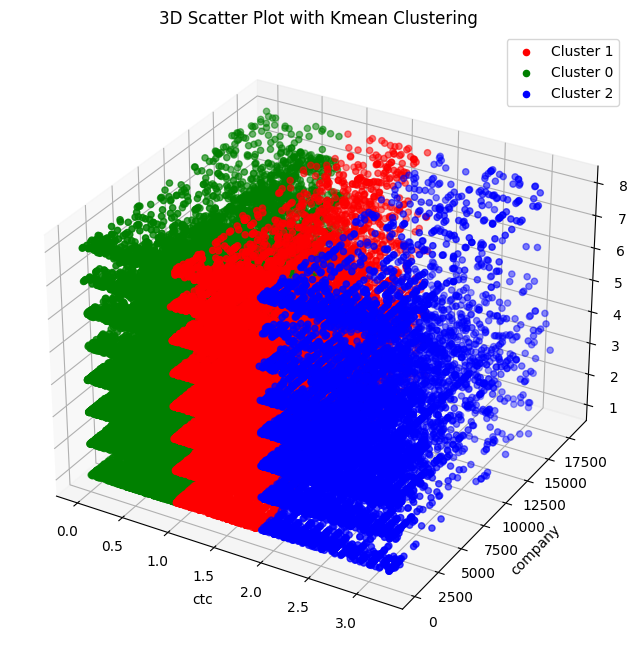

In [ ]:
#kmean


# Define features for clustering
features = ['ctc', 'company', 'position']

# Perform clustering
X = df[features]
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
df['kmean'] = kmeans.fit_predict(X)

# Plot 3D scatter plot with clusters as hue
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['r', 'g', 'b']

for cluster, color in zip(df['kmean'].unique(), colors):
    cluster_df = df[df['kmean'] == cluster]
    ax.scatter(cluster_df[features[0]], cluster_df[features[1]], cluster_df[features[2]], c=color, label=f'Cluster {cluster}')

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('3D Scatter Plot with Kmean Clustering')
ax.legend()
plt.show()

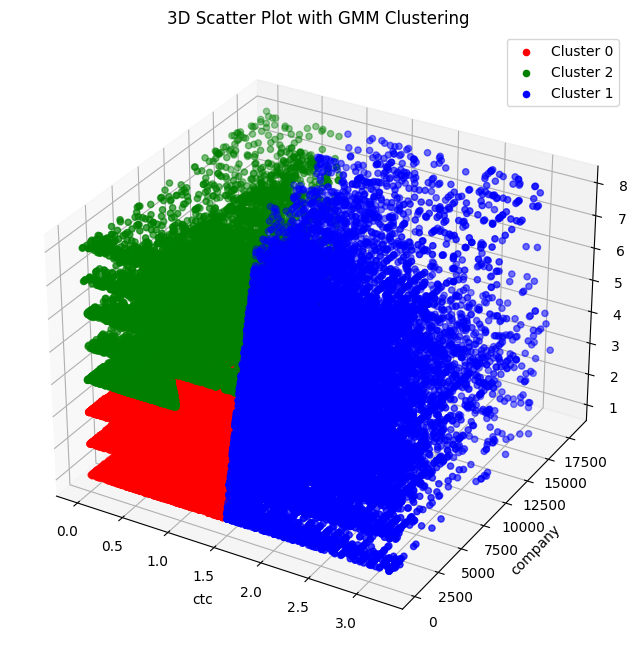

In [ ]:
#gmm


# Define features for clustering
features = ['ctc', 'company', 'position']

# Perform clustering with GMM
X = df[features]
gmm = GaussianMixture(n_components=3, covariance_type= 'tied',init_params = 'random',random_state=42)  # You can adjust the number of components (clusters)
df['gmm'] = gmm.fit_predict(X)

# Plot 3D scatter plot with clusters as hue
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['r', 'g', 'b','y','c']

for cluster, color in zip(df['gmm'].unique(), colors):
    cluster_df = df[df['gmm'] == cluster]
    ax.scatter(cluster_df[features[0]], cluster_df[features[1]], cluster_df[features[2]], c=color, label=f'Cluster {cluster}')

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('3D Scatter Plot with GMM Clustering')
ax.legend()
plt.show()

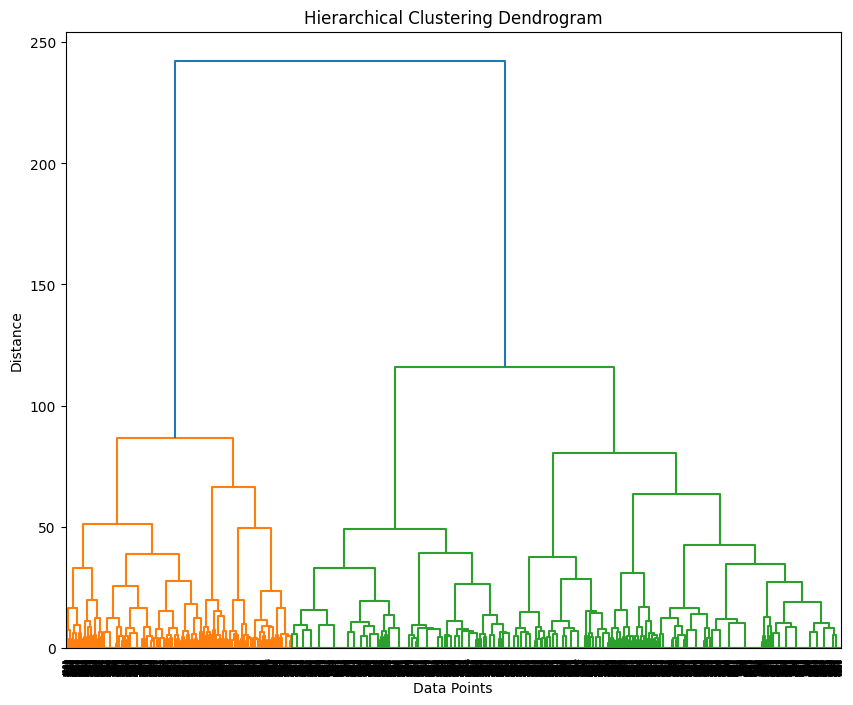

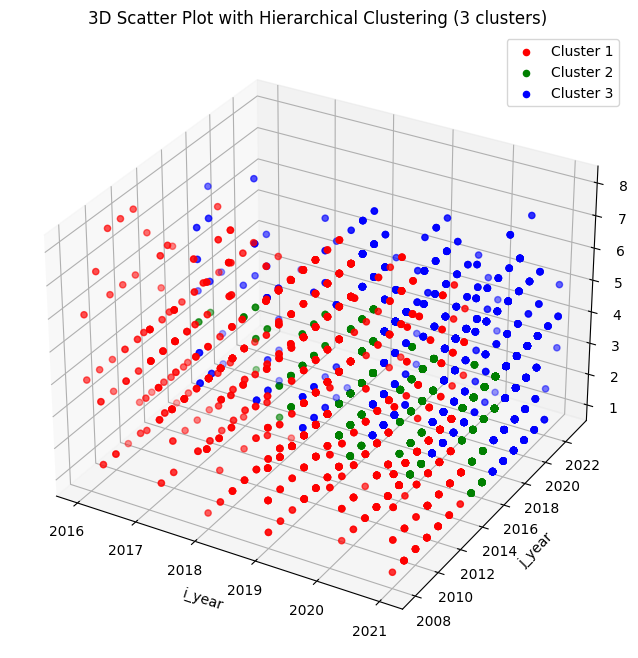

In [ ]:


df_5k = df.sample(n=5000, random_state=42)

# Define features for clustering
features = ['i_year', 'j_year', 'position']

# Perform hierarchical clustering
X = df_5k[features]
Z = linkage(X, method='ward')  # You can choose different linkage methods

# Plot dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Cut the dendrogram to obtain 3 clusters
k = 3  # Number of clusters
clusters = fcluster(Z, k, criterion='maxclust')
df_5k['Hiererarchical'] = clusters

# Plot 3D scatter plot with clusters as hue
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['r', 'g', 'b']

for cluster, color in zip(range(1, k+1), colors):
    cluster_df = df_5k[clusters == cluster]
    ax.scatter(cluster_df[features[0]], cluster_df[features[1]], cluster_df[features[2]], c=color, label=f'Cluster {cluster}')

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('3D Scatter Plot with Hierarchical Clustering (3 clusters)')
ax.legend()
plt.show()

In [ ]:


# Sample the dataframe
df_k = df.sample(n=10000, random_state=42)

# Define features for clustering
features = ['ctc', 'company', 'position', 'i_year', 'j_year', 'email']

# Generate all combinations of 3 features
feature_combinations = list(itertools.combinations(features, 3))

# Plot each combination in subplots
for i, combo in enumerate(feature_combinations, start=1):
    X = df_k[list(combo)]
    X_scaled = StandardScaler().fit_transform(X)  # Standardize features for GMM
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
    df_k[f'cluster_{i}'] = gmm.fit_predict(X_scaled)

    #fig = plt.figure(figsize=(7, 4))
    #ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with color and opacity
    #for cluster in df_k[f'cluster_{i}'].unique():
    #    cluster_df = df_k[df_k[f'cluster_{i}'] == cluster]
    #    ax.scatter(cluster_df[combo[0]], cluster_df[combo[1]], cluster_df[combo[2]], label=f'Cluster {cluster}')

    # Labels and title
    #ax.set_xlabel(combo[0])
    #ax.set_ylabel(combo[1])
    #ax.set_zlabel(combo[2])
    #ax.set_title(f'Cluster Plot for {combo}')
    #ax.legend()

    #plt.show()

In [ ]:
#Decoding position back to string

df['position'] = df['position'].astype('int32')
df['position'] = encoder.inverse_transform(df['position'],pos_dict)
df.head()

,company,email,j_year,ctc,position,i_year,ctc_increase,position_change,job_stability,experience,employee_count,kmean,gmm
0,52.0,37351.0,2016.0,1100000.0,other,2020.0,0.0,2.0,0.0,9.0,9.0,1,0
1,53.0,37352.0,2018.0,449999.0,fullstack engineer,2019.0,0.0,2.0,0.0,7.0,429.0,0,0
2,55.0,37354.0,2017.0,700000.0,backend engineer,2019.0,0.0,1.0,0.0,8.0,70.0,0,0
3,56.0,37355.0,2017.0,1400000.0,fullstack engineer,2019.0,0.0,2.0,0.0,8.0,6.0,1,0
4,57.0,37356.0,2018.0,700000.0,fullstack engineer,2020.0,0.0,2.0,0.0,7.0,6.0,0,0


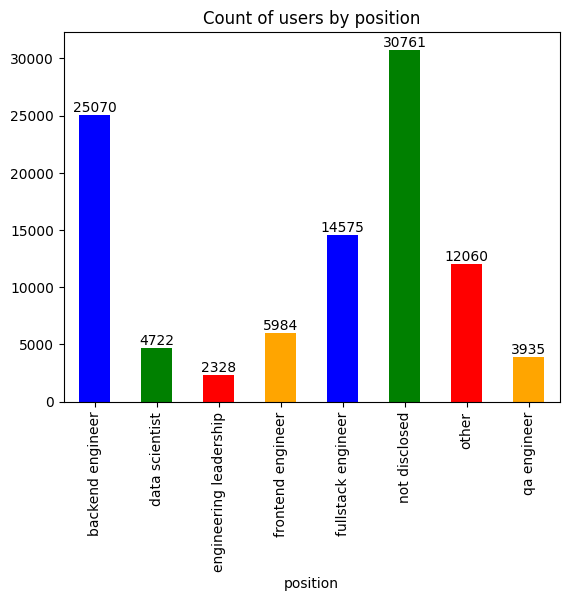

In [242]:
# count by Position


grouped_df = df.groupby('position')['email'].nunique()
grouped_df.plot(kind='bar', color=['blue', 'green', 'red', 'orange']) # Change colors as needed

# Adding count on top of each bar
for i, v in enumerate(grouped_df):
    plt.annotate(str(round(v, 2)), xy=(i, v), ha='center', va='bottom')

plt.title('Count of users by position')
plt.show()

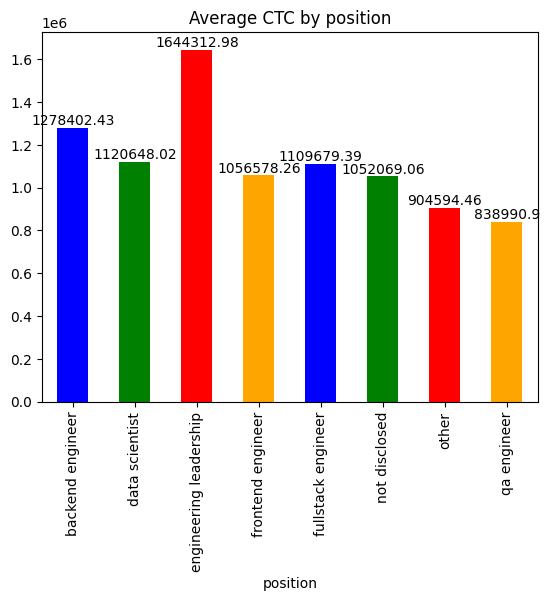

In [ ]:

grouped_df = df.groupby('position')['ctc'].mean()
grouped_df.plot(kind='bar', color=['blue', 'green', 'red', 'orange']) # Change colors as needed

# Adding count on top of each bar
for i, v in enumerate(grouped_df):
    plt.annotate(str(round(v, 2)), xy=(i, v), ha='center', va='bottom')

plt.title('Average CTC by position')
plt.show()

In [ ]:
for col in df.columns:
   Mi = df[col].isna().sum()
   print(f"{col} :{Mi}")

company :0
email :0
j_year :0
ctc :0
position :0
i_year :0
ctc_increase :0
position_change :0
job_stability :0
experience :0
employee_count :0
kmean :0
gmm :0


<Axes: title={'center': 'Average CTC by Position over years cluster 2'}, xlabel='i_year'>

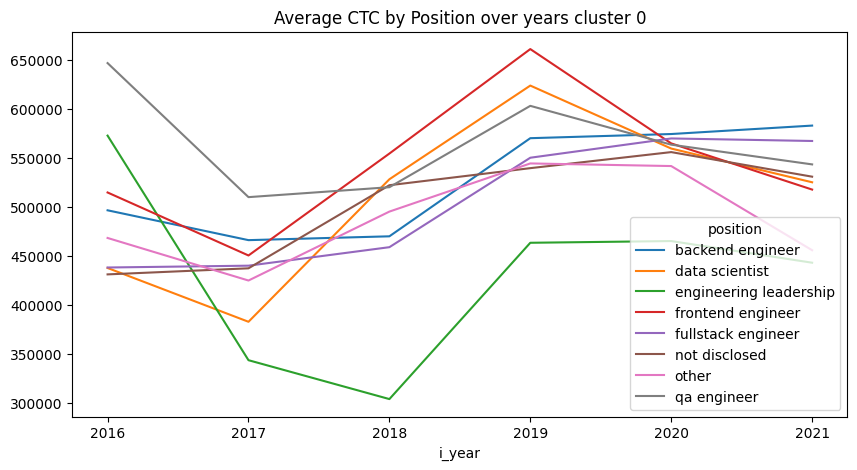

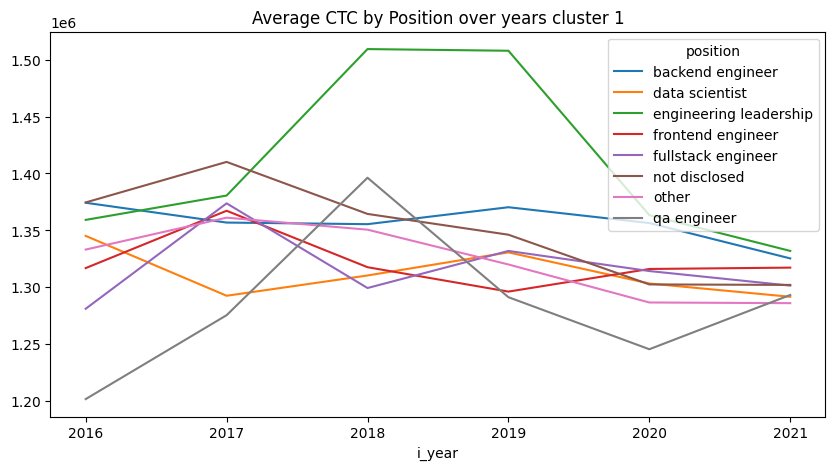

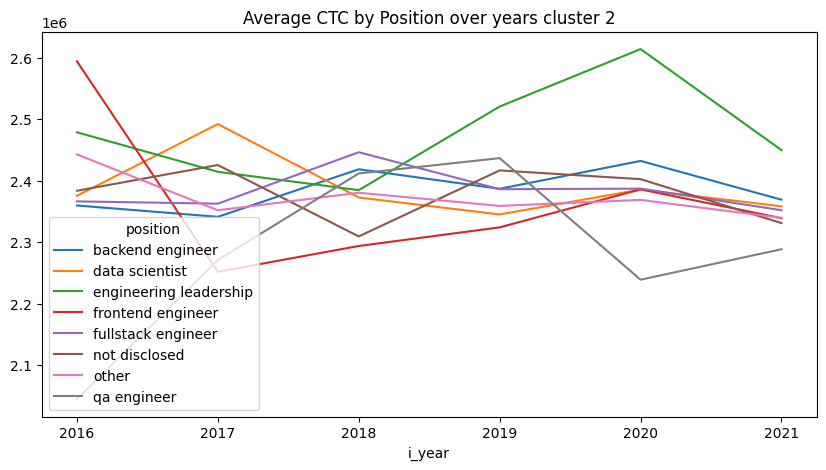

In [ ]:
# title Average CTC by Position over Time

df[df['kmean']==0].groupby([ 'i_year','position'])['ctc'].mean().unstack().plot(kind='line', title='Average CTC by Position over years cluster 0', figsize=(10, 5))
df[df['kmean']==1].groupby([ 'i_year','position'])['ctc'].mean().unstack().plot(kind='line', title='Average CTC by Position over years cluster 1', figsize=(10, 5))
df[df['kmean']==2].groupby([ 'i_year','position'])['ctc'].mean().unstack().plot(kind='line', title='Average CTC by Position over years cluster 2', figsize=(10, 5))

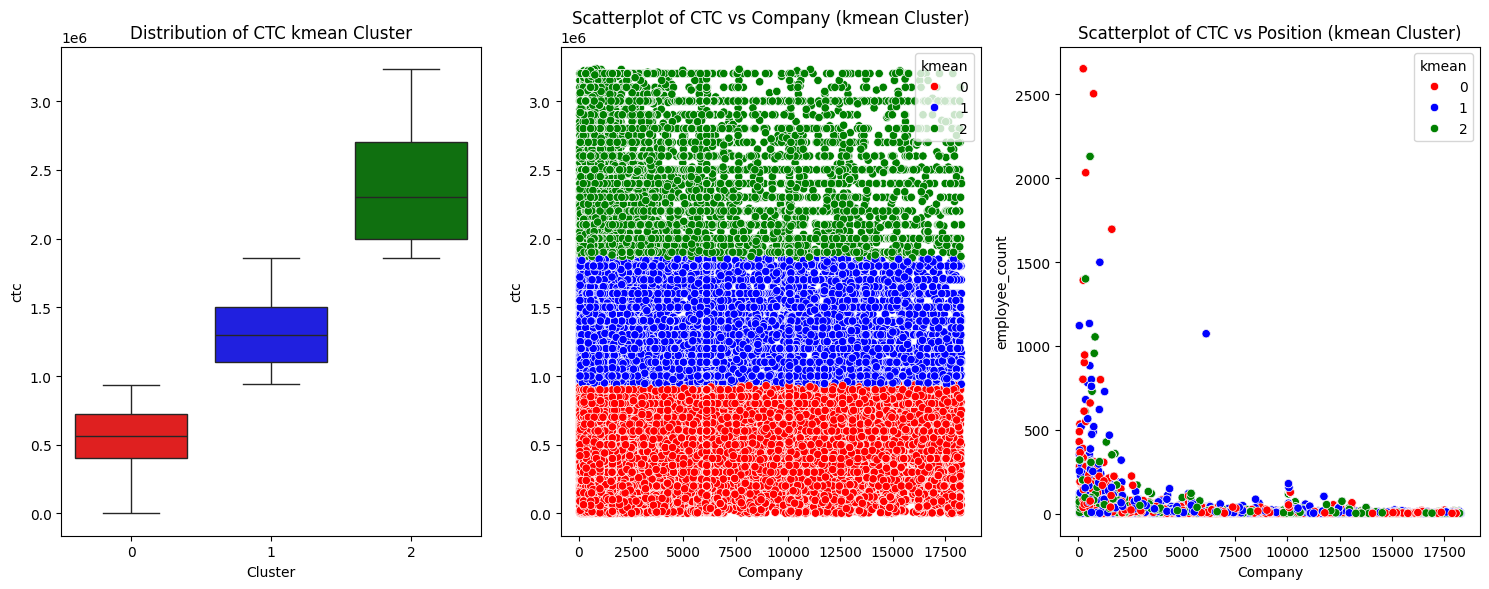

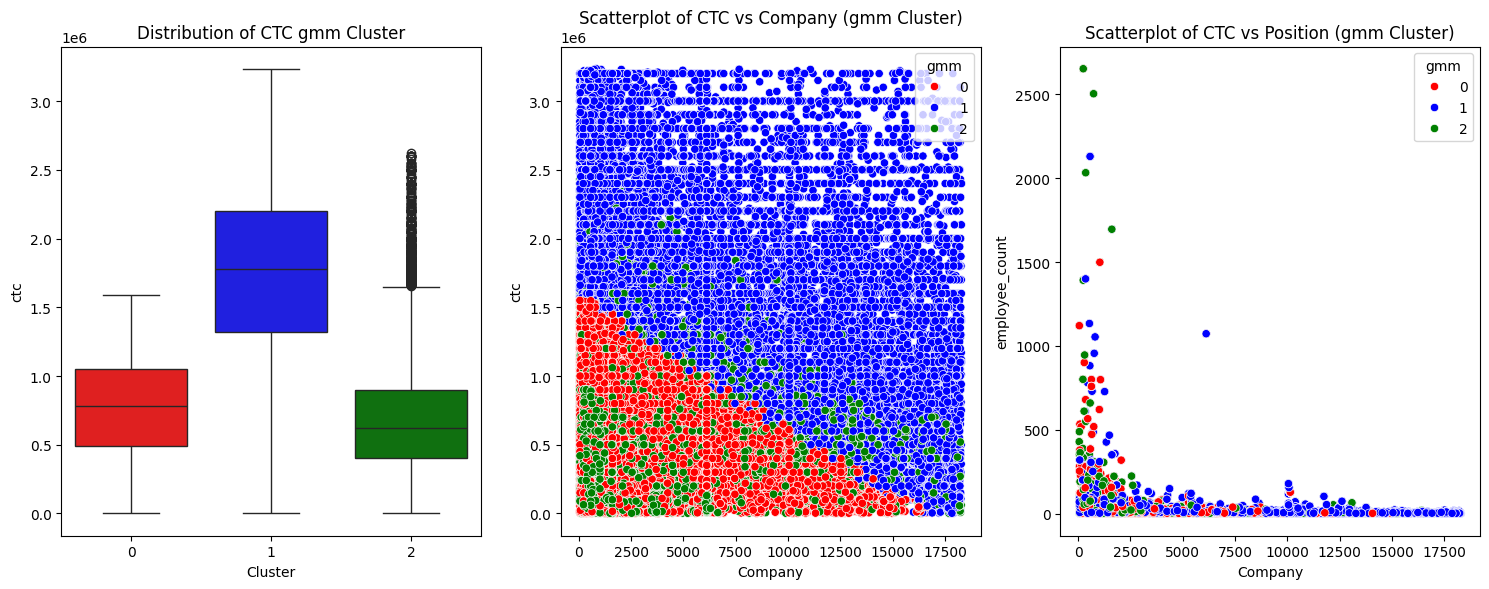

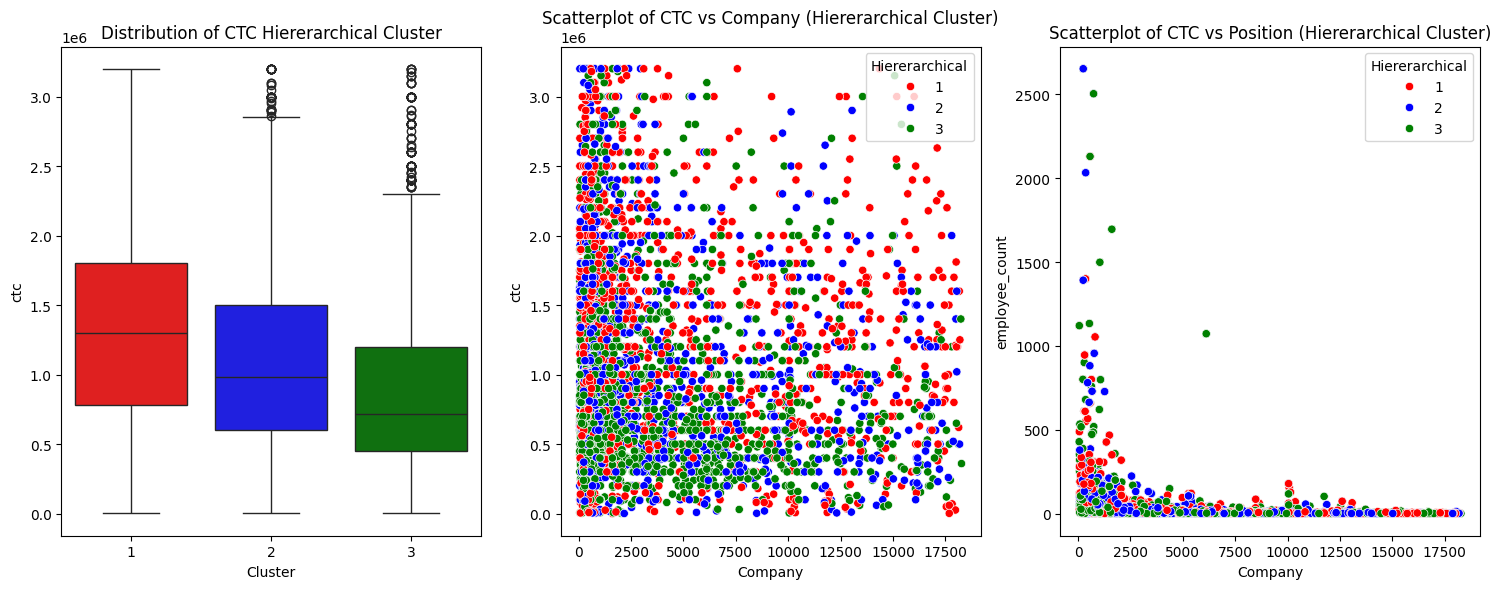

In [ ]:


feature = 'kmean'



clusters = df[feature].unique()
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Plot settings
plot_settings = [
    ('Distribution of CTC '+feature +' Cluster', 'cluster', 'ctc'),
    ('Scatterplot of CTC vs Company ('+feature +' Cluster)', 'company', 'ctc'),
    ('Scatterplot of CTC vs Position ('+feature +' Cluster)', 'company', 'employee_count')
]

# Plotting loop
for ax, (title, x_col, y_col) in zip(axs, plot_settings):
    if 'Distribution' in title:
        col_palette = {'0': 'red', '1': 'blue', '2': 'green'}
        sns.boxplot(x=feature, y='ctc', data=df , palette = col_palette, ax=ax)
    else:
        col_palette = {0: 'red', 1: 'blue', 2: 'green'}
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=feature, palette = col_palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_col.capitalize())
    ax.set_ylabel(y_col)

plt.tight_layout()
plt.show()

feature = 'gmm'


clusters = df[feature].unique()
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Plot settings
plot_settings = [
    ('Distribution of CTC '+feature +' Cluster', 'cluster', 'ctc'),
    ('Scatterplot of CTC vs Company ('+feature +' Cluster)', 'company', 'ctc'),
    ('Scatterplot of CTC vs Position ('+feature +' Cluster)','company', 'employee_count')
]

# Plotting loop
for ax, (title, x_col, y_col) in zip(axs, plot_settings):
    if 'Distribution' in title:
        col_palette = {'0': 'red', '1': 'blue', '2': 'green'}
        sns.boxplot(x=feature, y='ctc', data=df , palette = col_palette, ax=ax)
    else:
        col_palette = {0: 'red', 1: 'blue', 2: 'green'}
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=feature, palette = col_palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_col.capitalize())
    ax.set_ylabel(y_col)

plt.tight_layout()
plt.show()



feature = 'Hiererarchical'


clusters = df_5k[feature].unique()
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Plot settings
plot_settings = [
    ('Distribution of CTC '+feature +' Cluster', 'cluster', 'ctc'),
    ('Scatterplot of CTC vs Company ('+feature +' Cluster)', 'company', 'ctc'),
    ('Scatterplot of CTC vs Position ('+feature +' Cluster)', 'company', 'employee_count')
]

# Plotting loop
for ax, (title, x_col, y_col) in zip(axs, plot_settings):
    if 'Distribution' in title:
        col_palette = {'1': 'red', '2': 'blue', '3': 'green'}
        sns.boxplot(x=feature, y='ctc', data=df_5k , palette = col_palette, ax=ax)
    else:
        col_palette = {1: 'red', 2: 'blue', 3: 'green'}
        sns.scatterplot(data=df_5k, x=x_col, y=y_col, hue=feature, palette = col_palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_col.capitalize())
    ax.set_ylabel(y_col)

plt.tight_layout()
plt.show()